[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mductran/Bottle-Classifier/blob/master/BottleClassifier.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import tensorflow as tf
import os
import glob
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import cv2
from keras.preprocessing.image import ImageDataGenerator
from random import randint
from sklearn.model_selection import train_test_split
from skimage.transform import pyramid_gaussian

Using TensorFlow backend.


In [0]:
labels = {0: '7up',
         1: 'aquafina',
         2: 'cafe',
         3: 'chanh',
         4: 'drthanh',
         5: 'fuzetea',
         6: 'lavie',
         7: 'mountaindew',
         8: 'olong',
         9: 'ovaltine',
         10: 'soda',
         11: 'babydream',
         12: 'ginkgo',
}

In [0]:
img_dir = "/content/gdrive/My Drive/STU.AI/camera/training_data_2nd/"
data = pd.read_csv(img_dir+'label.csv')

X_data = []
Y_data = []

image_size = (32, 32)
data = shuffle(data)

for i in range(len(data)):
    filename = data.iloc[i,0]
    label = data.iloc[i,2]
        
    img = plt.imread(img_dir+filename)
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)
    X_data.append(img)
    Y_data.append(label)
    
X_data = np.array(X_data)
Y_data = np.array(Y_data)
n_classes = int(max(Y_data))+1

In [0]:
rgb2gray = [0.299, 0.587, 0.114]
# Convert images to grayscale
X_gray = np.dot(X_data[...,:3], rgb2gray)

# Normalize images
X_gray = (X_gray/255-0.5)*2
X_gray = X_gray.reshape(*X_gray.shape, 1)

In [0]:
def dataAug(X_train, y_train):
    datagen = ImageDataGenerator(rotation_range=10,zoom_range=0.10)
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=X_train.shape[0], shuffle=False):
        X_train_aug = x_batch.astype('uint8')
        y_train_aug = y_batch
        break

    X_train = np.concatenate([X_train, X_train_aug])
    y_train = np.concatenate([y_train,y_train_aug])
    return X_train,y_train

In [9]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(1, 1, 1, 6), mean = mu, stddev = sigma))
    conv1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID', name='conv1')
    b1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.bias_add(conv1, b1)
    # print("layer 1 shape:",conv1.get_shape())

    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # TODO: Pooling. Input = 32x32x6. Output = 16x16x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Input = 16x16x6. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(7, 7, 6, 16), mean = mu, stddev = sigma))
    conv2 = tf.nn.conv2d(conv1, W2, strides=[1, 1, 1, 1], padding='VALID', name='conv2')
    b2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.bias_add(conv2, b2)
    # print("layer 2 shape:",conv2.get_shape())
                    
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    full1 = tf.add(tf.matmul(conv2, W3), b3)
    # print("layer 3 shape:", full1.get_shape())
    
    # TODO: Activation.
    full1 = tf.nn.relu(full1)
    
    # Dropout
    # full1 = tf.nn.dropout(full1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    full2 = tf.add(tf.matmul(full1, W4), b4)
    # print("layer 4 shape:", full2.get_shape())
    
    # TODO: Activation.
    full2 = tf.nn.relu(full2)
    
    # Dropout
    # full2 = tf.nn.dropout(full2, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 13.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 13), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(13)) 
    logits = tf.add(tf.matmul(full2, W5), b5)
    print("output shape:", logits.get_shape())
    
    return logits

print('done')

done


In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

learning_rate = 0.001
EPOCHS = 50
BATCH_SIZE = 128

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy*len(batch_x))
    return total_accuracy/num_examples,logits

output shape: (?, 13)


In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    X_train,X_valid,y_train,y_valid = train_test_split(X_gray, Y_data, test_size = 0.3, random_state=50)
           
    X_train, y_train = dataAug(X_train, y_train)

    num_examples = len(X_train)
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy,_ = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    save_path = saver.save(sess, '/content/gdrive/My Drive/model/bottle.ckpt')

EPOCH 1 ...
Validation Accuracy = 0.190
EPOCH 2 ...
Validation Accuracy = 0.216
EPOCH 3 ...
Validation Accuracy = 0.253
EPOCH 4 ...
Validation Accuracy = 0.311
EPOCH 5 ...
Validation Accuracy = 0.388
EPOCH 6 ...
Validation Accuracy = 0.425
EPOCH 7 ...
Validation Accuracy = 0.480
EPOCH 8 ...
Validation Accuracy = 0.630
EPOCH 9 ...
Validation Accuracy = 0.659
EPOCH 10 ...
Validation Accuracy = 0.714
EPOCH 11 ...
Validation Accuracy = 0.711
EPOCH 12 ...
Validation Accuracy = 0.733
EPOCH 13 ...
Validation Accuracy = 0.769
EPOCH 14 ...
Validation Accuracy = 0.747
EPOCH 15 ...
Validation Accuracy = 0.799
EPOCH 16 ...
Validation Accuracy = 0.791
EPOCH 17 ...
Validation Accuracy = 0.817
EPOCH 18 ...
Validation Accuracy = 0.832
EPOCH 19 ...
Validation Accuracy = 0.817
EPOCH 20 ...
Validation Accuracy = 0.817
EPOCH 21 ...
Validation Accuracy = 0.839
EPOCH 22 ...
Validation Accuracy = 0.850
EPOCH 23 ...
Validation Accuracy = 0.821
EPOCH 24 ...
Validation Accuracy = 0.821
EPOCH 25 ...
Validation A

In [0]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5)):
					
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[0]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[1]
	
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
	
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
	
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
	
    # Initialize a list to append window positions to
    window_list = []
	
    # Loop through finding x and y window positions
    for xs in range(nx_windows):
        for ys in range(ny_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
        
	# Return the list of windows
    return window_list

[((0, 0), (32, 32)), ((0, 16), (32, 48)), ((0, 32), (32, 64)), ((0, 48), (32, 80)), ((0, 64), (32, 96)), ((0, 80), (32, 112)), ((0, 96), (32, 128)), ((0, 112), (32, 144)), ((0, 128), (32, 160)), ((0, 144), (32, 176)), ((0, 160), (32, 192)), ((0, 176), (32, 208)), ((0, 192), (32, 224)), ((0, 208), (32, 240)), ((0, 224), (32, 256)), ((0, 240), (32, 272)), ((0, 256), (32, 288)), ((0, 272), (32, 304)), ((0, 288), (32, 320)), ((0, 304), (32, 336)), ((0, 320), (32, 352)), ((0, 336), (32, 368)), ((0, 352), (32, 384)), ((0, 368), (32, 400)), ((0, 384), (32, 416)), ((0, 400), (32, 432)), ((0, 416), (32, 448)), ((0, 432), (32, 464)), ((0, 448), (32, 480)), ((0, 464), (32, 496)), ((0, 480), (32, 512)), ((0, 496), (32, 528)), ((0, 512), (32, 544)), ((0, 528), (32, 560)), ((0, 544), (32, 576)), ((0, 560), (32, 592)), ((0, 576), (32, 608)), ((0, 592), (32, 624)), ((0, 608), (32, 640)), ((16, 0), (48, 32)), ((16, 16), (48, 48)), ((16, 32), (48, 64)), ((16, 48), (48, 80)), ((16, 64), (48, 96)), ((16, 

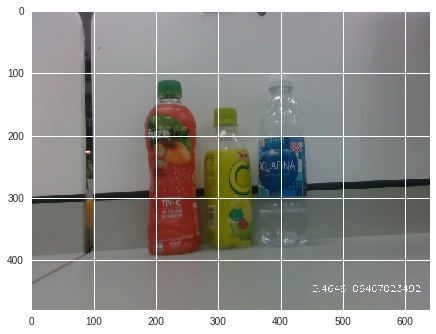

In [22]:
img_dir = '/content/gdrive/My Drive/model/testimg.jpg'
img = mpimg.imread(img_dir)
plt.imshow(img)

box = slide_window(img)
print(box)

In [23]:
img = cv2.imread('/content/gdrive/My Drive/model/testimg.jpg')
pyramid = tuple(pyramid_gaussian(img, max_layer=0))
print(len(pyramid))

img = np.dot(img[...,:3], rgb2gray)
img = img[:,:,np.newaxis]

init = tf.global_variables_initializer()

1


In [32]:
for scaled in pyramid:
    coordinates = slide_window(scaled)
    i=0
    for pair in coordinates:
        box = img[pair[0][0]:pair[1][0], pair[0][1]:pair[1][1]]
        box = tf.convert_to_tensor(box, dtype=tf.float32)
        box = tf.expand_dims(box, 0)
        print('x: ', [pair[0][0], pair[0][1]], 'y: ', [pair[1][0], pair[1][1]], 'i: ', i)
        i += 1
        
        logits = LeNet(box)
        accuracy = tf.nn.softmax(logits)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            print('accuracy: ', sess.run(accuracy))
            
        # label = labels[logits.index[accuracy]]
        
        # print('label: ', label, 'accuracy: ', accuracy)

x:  [0, 0] y:  [32, 32] i:  0
output shape: (1, 13)
accuracy:  [[6.1010287e-11 9.9302131e-09 2.0658696e-10 1.7173958e-01 3.2172278e-07
  9.2611890e-12 6.1763826e-06 9.1505246e-03 3.6458836e-08 8.1909323e-01
  2.0597446e-09 1.0150120e-05 1.2975788e-09]]
x:  [0, 16] y:  [32, 48] i:  1
output shape: (1, 13)
accuracy:  [[1.0418785e-03 5.5133737e-06 7.0004758e-09 9.8917645e-01 1.5862676e-09
  1.4931372e-08 1.9162711e-05 9.6995849e-03 4.1106294e-05 1.0516950e-06
  2.0924740e-07 1.5117303e-05 9.2041591e-10]]
x:  [0, 32] y:  [32, 64] i:  2
output shape: (1, 13)


KeyboardInterrupt: ignored